# Skin lesion classification
### Gabriela BITTENCOURT

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [3]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

ModuleNotFoundError: No module named 'google_drive_downloader'

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [5]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

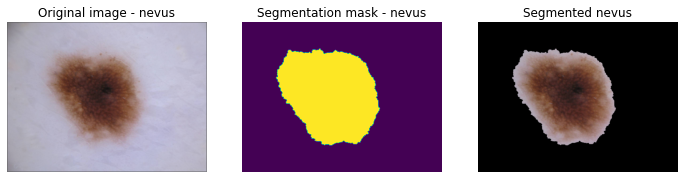

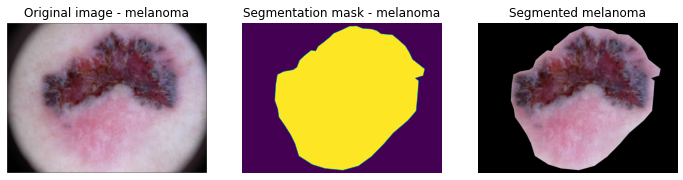

In [6]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [7]:
# Shuffle data randomly
indeces=np.arange(N)
np.random.shuffle(indeces)

Xp=X[indeces]
yp=y[indeces]

data_shuf={
    'X' : X[indeces],
    'y' : y[indeces] }

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

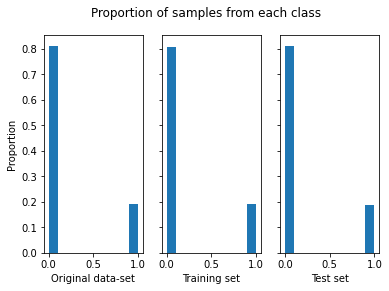

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

In [9]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data_scal={
    'X'     : X_train,
    'y'     : y_train }

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

In [10]:
def compute_n_plot_confusion_matrix(y_pred,technique=''):
    """
    Compute and plot the confusion matrix

    Parameters
    ----------
    y_pred: [N,] vector
        predicted result using the model
    technique: 'LDA' or 'QDA'
        estimator's technique to be used: Linear Discriminant Analysis or Quadratic Discriminant Analysis
    """

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='{0} Normalized confusion matrix'.format(technique))
    plt.show()


Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       146
           1       0.47      0.24      0.31        34

    accuracy                           0.81       180
   macro avg       0.66      0.59      0.60       180
weighted avg       0.77      0.81      0.78       180

Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.76470588 0.23529412]]


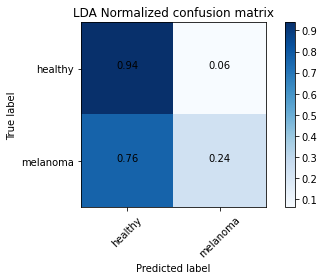

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       146
           1       0.55      0.32      0.41        34

    accuracy                           0.82       180
   macro avg       0.70      0.63      0.65       180
weighted avg       0.80      0.82      0.80       180

Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.67647059 0.32352941]]


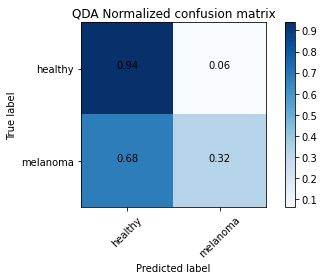

In [11]:
estimator={
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
}

def fit_estimator(data,technique):
    """
    Fit the estimator (LDA or QDA) to training set data and plot the confusion matrix

    Parameters
    ----------
    data: dict ['X' , 'y']
        X,y vector data used to train the model
    technique: 'LDA' or 'QDA'
        estimator's technique to be used: Linear Discriminant Analysis or Quadratic Discriminant Analysis
    """

    print("Fitting {0} to training set".format(technique))
    estimator[technique].fit(data['X'], data['y'])
    y_pred = estimator[technique].predict(X_test)
    print(classification_report(y_test, y_pred))

    compute_n_plot_confusion_matrix(y_pred,technique)

# Fitting LDA
fit_estimator(data_scal,'LDA')

# Fitting QDA
fit_estimator(data_scal,'QDA')

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

In [13]:
estimator={
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
}

def cv_fitting(data,technique):
    """
    Calculate the cross validation score of a fitted estimator (LDA or QDA or KNN) to training set data

    Parameters
    ----------
    data: dict ['X' , 'y']
        X,y vector data used to train the model
    technique: 'LDA' or 'QDA' or 'KNN'
        estimator's technique to be used: Linear Discriminant Analysis, Quadratic Discriminant Analysis or K-Near Neighbors Classifier (here with 3 neighbors)
    """

    score = cross_val_score(estimator[technique],X=data['X'],y=data['y'],cv=5)
    print("Fitting {0} : Average and std CV score : {1} +- {2}".format(technique,score.mean(),score.std()))

When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

In [14]:
def best_hyperparam(data,estimator,p_grid,scoring):
    """
    Calculate the best hyperparameters using cv and plot the confusion matrix

    Parameters
    ----------
    data: dict ['X' , 'y']
        X,y vector data used to train the model
    technique: 'LDA' or 'QDA' or 'KNN'
        estimator's technique to be used: Linear Discriminant Analysis, Quadratic Discriminant Analysis or K-Near Neighbors Classifier (here with 3 neighbors)
    p_grid:
        grid that will serve as parameter on the GridSearchCV function
    scoring: 
        technique of scoring to be used on GridSearchCV function
    """

    grid = GridSearchCV(estimator=estimator, param_grid=p_grid, scoring=scoring, cv=5)
    grid.fit(data['X'], data['y'])
    print("Best training Score: {}".format(grid.best_score_))
    print("Best training params: {}".format(grid.best_params_))
    y_pred = grid.predict(X_test)

    compute_n_plot_confusion_matrix(y_pred)
    

Best training Score: 0.8285714285714285
Best training params: {'n_neighbors': 8}
Normalized confusion matrix
[[0.98630137 0.01369863]
 [0.79411765 0.20588235]]


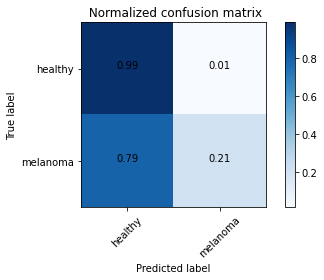

In [15]:
# Looking for the best hyperparameters
p_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()

best_hyperparam(data_scal,KNN,p_grid=p_grid,scoring="accuracy")

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.357525126325726
Best training params: {'n_neighbors': 3}
Normalized confusion matrix
[[0.90410959 0.09589041]
 [0.64705882 0.35294118]]


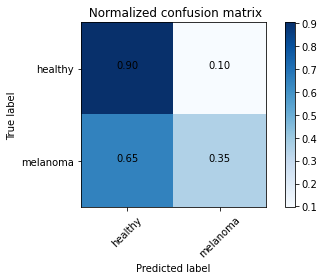

In [16]:
# Looking for the best hyperparameters
p_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()

best_hyperparam(data_scal,KNN,p_grid,scoring="f1")

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

In [17]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

data_resamp={
    'X'     : X_resampled,
    'y'     : y_resampled }

[(0, 339), (1, 339)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.8966884531590414
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.82191781 0.17808219]
 [0.58823529 0.41176471]]


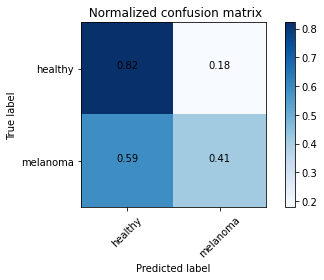

Best training Score: 0.9068670300375195
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.82191781 0.17808219]
 [0.58823529 0.41176471]]


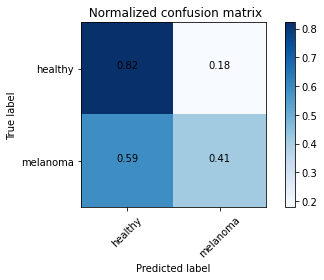

In [24]:
# Looking for the best hyperparameters
p_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()

best_hyperparam(data_resamp,KNN,p_grid,scoring="accuracy")

# Looking for the best hyperparameters
p_grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()

best_hyperparam(data_resamp,KNN,p_grid,scoring="f1")

Let's use the techniques seen today: Perceptron and linear SVM. 

In [25]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.8054166666666667 +- 0.002499999999999991
 Average and std TEST CV accuracy : 0.7983333333333335 +- 0.016158932858054417
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8150000000000001 +- 0.00549621081594703
 Average and std TEST CV accuracy : 0.7966666666666666 +- 0.010000000000000016


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [26]:
fit_func={
    'Perceptron': Perceptron,
    'Linear_SVM': LinearSVC,
}

In [18]:
def cross_validation(data,technique,return_estimator=False):
    """
    Calculate the estimator using cross validate function using "accuracy" and "f1" scores and print the results

    Parameters
    ----------
    data: dict ['X' , 'y']
        X,y vector data used to train the model
    technique: 'Perceptron' or 'Linear_SVM'
        estimator's technique to be used
    return_estimator: True or False
        includes(if True) or not(if False) the estimator on est_cv.keys

    Return
    ------
    est_cv:
        best scores of the estimator for each cv run
    """

    print("Fitting {0}".format(technique))
    estimator = fit_func[technique]()
    est_cv = cross_validate(estimator, data['X'], data['y'],cv=5,scoring=('accuracy', 'f1'), return_train_score=True,return_estimator=return_estimator)
    print(est_cv.keys())
    print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(est_cv['train_accuracy'].mean(), est_cv['train_accuracy'].std() ))
    print(" Average and std TEST CV accuracy : {0} +- {1}".format(est_cv['test_accuracy'].mean(), est_cv['test_accuracy'].std() ))
    print(" Average and std TRAIN CV f1 : {0} +- {1}".format(est_cv['train_f1'].mean(), est_cv['train_f1'].std() ))
    print(" Average and std TEST CV f1 : {0} +- {1}".format(est_cv['test_f1'].mean(), est_cv['test_f1'].std() ))
    return est_cv

In [28]:
# Fitting Perceptron
cross_validation(data_shuf,'Perceptron')

# Fitting linear SVM 
cross_validation(data_shuf,'Linear_SVM')


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.8054166666666667 +- 0.002499999999999991
 Average and std TEST CV accuracy : 0.7983333333333335 +- 0.016158932858054417
 Average and std TRAIN CV f1 : 0.0431685273790537 +- 0.06796113424510031
 Average and std TEST CV f1 : 0.013333333333333332 +- 0.026666666666666665
Fitting Linear_SVM
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6837500000000001 +- 0.24500708606532634
 Average and std TEST CV accuracy : 0.6849999999999999 +- 0.24672296654795278
 Average and std TRAIN CV f1 : 0.12488274062190349 +- 0.11161630854232465
 Average and std TEST CV f1 : 0.13305361305361307 +- 0.1356384118007164


{'fit_time': array([0.09192944, 0.04804015, 0.05035377, 0.06382966, 0.05068541]),
 'score_time': array([0.00081563, 0.00107741, 0.00147891, 0.0012691 , 0.00122213]),
 'test_accuracy': array([0.8       , 0.80833333, 0.19166667, 0.81666667, 0.80833333]),
 'train_accuracy': array([0.80833333, 0.80833333, 0.19375   , 0.80416667, 0.80416667]),
 'test_f1': array([0.07692308, 0.        , 0.32167832, 0.26666667, 0.        ]),
 'train_f1': array([0.14814815, 0.        , 0.32224168, 0.11320755, 0.04081633])}

**Question** Please do the same on the oversampled data and compare the results with the previous ones.

In [29]:
X_resampled_All, y_resampled_All = ros.fit_resample(Xp, yp)

data_resAll={
    'X'     : X_resampled_All,
    'y'     : y_resampled_All,}

# Fitting Perceptron
cross_validation(data_resAll,'Perceptron')

# Fitting linear SVM 
cross_validation(data_resAll,'Linear_SVM')

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5293814432989691 +- 0.028413706520770673
 Average and std TEST CV accuracy : 0.5268041237113402 +- 0.024699275362290617
 Average and std TRAIN CV f1 : 0.38755858757838135 +- 0.24851014693672516
 Average and std TEST CV f1 : 0.38697352855949674 +- 0.24695483181563896
Fitting Linear_SVM
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5510309278350516 +- 0.06581305549807717
 Average and std TEST CV accuracy : 0.5247422680412371 +- 0.03958011097000508
 Average and std TRAIN CV f1 : 0.35144789458781805 +- 0.2832338332679078
 Average and std TEST CV f1 : 0.31980217168007724 +- 0.2699769435514426


{'fit_time': array([0.09041548, 0.06421661, 0.10682273, 0.07898855, 0.07822299]),
 'score_time': array([0.00132656, 0.00261903, 0.00083566, 0.00137258, 0.00127149]),
 'test_accuracy': array([0.51030928, 0.53092784, 0.5       , 0.59793814, 0.48453608]),
 'train_accuracy': array([0.50386598, 0.58634021, 0.5       , 0.66494845, 0.5       ]),
 'test_f1': array([0.05940594, 0.28346457, 0.66666667, 0.58947368, 0.        ]),
 'train_f1': array([0.02035623, 0.37181996, 0.66666667, 0.65879265, 0.03960396])}

We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

In [30]:
def cv_and_best_est(data,technique):
    """
    Calculate the estimator using cross validate function and compute best estimator
    
    Parameters
    ----------
    data: dict ['X' , 'y']
        X,y vector data used to train the model
    technique: 'Perceptron' or 'Linear_SVM'
        estimator's technique to be used
    """
    
    est_cv = cross_validation(data,technique,return_estimator=True)
    
    # Look for the best estimator (the one with the greatest test accuracy)
    index_best = np.argmax(est_cv['test_accuracy'])
    estimator_best=est_cv['estimator'][index_best]
    y_pred = estimator_best.predict(X_test)

    compute_n_plot_confusion_matrix(y_pred,technique)

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6574456518045844 +- 0.021851908276301745
 Average and std TEST CV accuracy : 0.6356427015250545 +- 0.05704511902010065
 Average and std TRAIN CV f1 : 0.6694588340715046 +- 0.021419240238278858
 Average and std TEST CV f1 : 0.6613890955958334 +- 0.050859455801670464
Normalized confusion matrix
[[0.65753425 0.34246575]
 [0.44117647 0.55882353]]


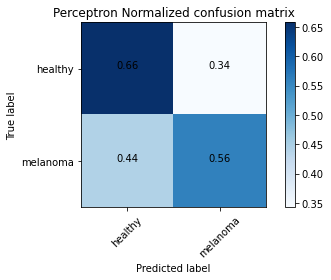

Fitting Linear_SVM
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7145922950942217 +- 0.013508706135269086
 Average and std TEST CV accuracy : 0.6916775599128541 +- 0.03394436542191093
 Average and std TRAIN CV f1 : 0.7015079641688822 +- 0.015436856702216766
 Average and std TEST CV f1 : 0.6860781193933474 +- 0.030175778966287065
Normalized confusion matrix
[[0.80821918 0.19178082]
 [0.38235294 0.61764706]]


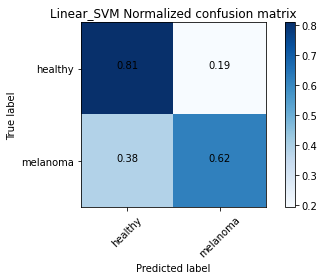

In [31]:
# Fitting Perceptron
cv_and_best_est(data_resamp,'Perceptron')

# Fitting linear SVM
cv_and_best_est(data_resamp,'Linear_SVM')

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Fitting Linear SVM to the training set
Best training Score: 0.6946187363834423
Best training params: {'C': 1}
Normalized confusion matrix
[[0.80821918 0.19178082]
 [0.41176471 0.58823529]]


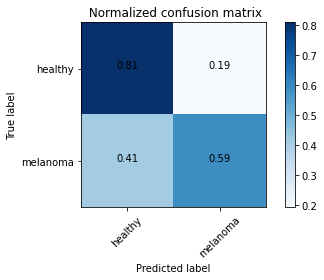

In [32]:
# Looking for the best hyperparameter C
print("Fitting Linear SVM to the training set")
t0 = time()

p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()

best_hyperparam(data_resamp,Lsvm,p_grid_lsvm,scoring="accuracy")

dt = time()-t0

In [33]:
print("--- time to calculate Linear SVM = {0}".format(dt))

--- time to calculate Linear SVM = 1.8040120601654053


Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.9719281045751634
Best training params: {'C': 4, 'gamma': 0.1}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


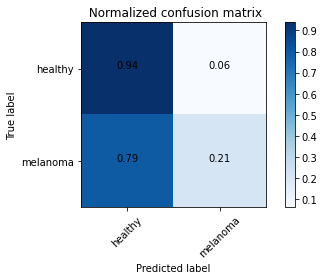

In [34]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
best_hyperparam(data_resamp,NLsvm,p_grid_nlsvm,scoring="accuracy")

dt = time()-t0

In [35]:
print("--- time to calculate Non-linear SVM = {0}".format(dt))

--- time to calculate Non-linear SVM = 3.323591470718384


**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

Best training Score: 0.9727765627581917
Best training params: {'C': 4, 'gamma': 0.1}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.79411765 0.20588235]]


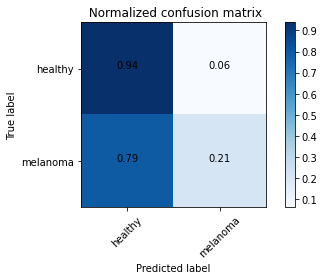

In [36]:
# change scoring

NLsvm = SVC(kernel='rbf')
best_hyperparam(data_resamp,NLsvm,p_grid_nlsvm,scoring="f1")

Best training Score: 0.9958762886597938
Best training params: {'C': 1, 'gamma': 0.005}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


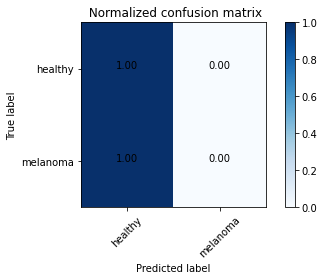

In [37]:
# data oversampled

NLsvm = SVC(kernel='rbf')
best_hyperparam(data_resAll,NLsvm,p_grid_nlsvm,scoring="accuracy")

Best training Score: 0.9958333333333332
Best training params: {'C': 1, 'gamma': 0.005}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


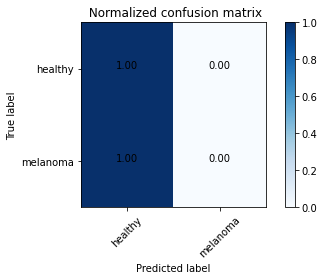

In [38]:
# different scoring and data oversampled

NLsvm = SVC(kernel='rbf')
best_hyperparam(data_resAll,NLsvm,p_grid_nlsvm,scoring="f1")

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM
XXXXXXXX

In [ ]:
# Fitting Linear SVM 
XXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX